In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset
import events_utils.flow as flow_utils

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#define time range
t_start = 9.2
duration = 0.15
t_end = t_start + duration
shape = (180, 240)
dataset = "data/esim_data/circle/"

In [4]:
events_raw = np.loadtxt(path + dataset + "events.txt", max_rows=10000000)

In [5]:
sub_factor=1

In [9]:
patch_center = (80, 70)
patch_size = 50
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events_p = flt.filter_patch(events_raw, patch_center, patch_size)

In [10]:
events_conv, new_shape = flt.filter_conv(events_p, shape, factor=sub_factor)
shape = new_shape
print(shape)

(180, 180)


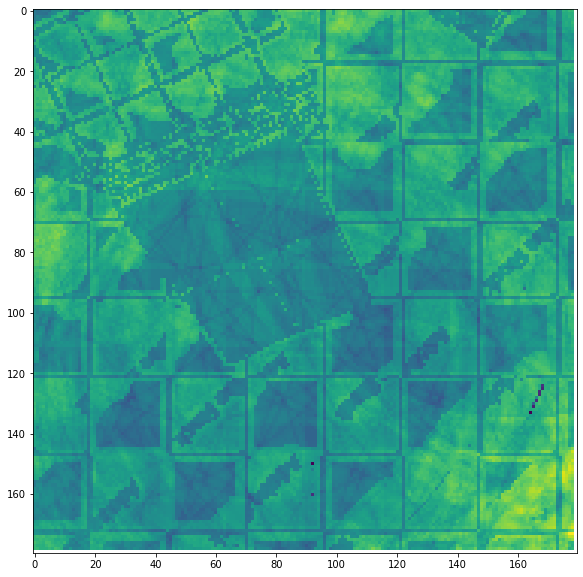

In [11]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2img(events_conv, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [ ]:
events = flt.filter_refract(events_conv, 0.2)

In [ ]:
events = flt.filter_time(events, t_start, t_end)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [ ]:
calib = np.loadtxt(path + dataset + "calib.txt") / sub_factor

In [ ]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")
# poses[:, [1, 2, 3]] = poses[:, [2, 3, 1]]

In [ ]:
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [ ]:
# U, V, std_u, std_v = td2d.measure_td2(events, shape, dist=1, px_range_pred=5, std_thr=1.1, mean_thr=100.01, start_delay=0.00, final_delay=0.00)
# U, V, std_u, std_v = td2d.measure_td2(events, shape, dist=1)

In [ ]:
U, V = td2d.measure_td_raw(events, shape, dist=1)

In [ ]:
std_u_m = np.ma.masked_where(std_u == 0.0, std_u)
plt.hist(std_u_m.compressed(), 100, range=(0, 0.01));

In [ ]:
m = np.sqrt(U**2 + V**2)

In [ ]:
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

In [ ]:
m_ma = np.ma.masked_where(np.isclose(m, 0.0), m)
plt.hist(m_ma.compressed(), 100);

In [ ]:
C = [calib[2], calib[3]]

In [ ]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

ang1 = R.from_quat(pose1[4:]).as_euler("xyz")
ang2 = R.from_quat(pose2[4:]).as_euler("xyz")

vel = (ang2 - ang1) / (pose2[0] - pose1[0])

print(vel)

In [ ]:
ang_U, ang_V = flow_utils.get_angular_flow(vel, calib[0], C, shape)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_U[::10, ::10], ang_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [ ]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 10]

t1 = pose1[1:4]
t2 = pose2[1:4]

print(t1)
print(t2)

t_vel = (t2 - t1) #/ (pose2[0] - pose1[0])

print(t_vel)
print(pose2[0] - pose1[0])

In [ ]:
t1

In [ ]:
t_U, t_V = flow_utils.get_translational_flow(t_vel, calib[0], C, shape)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(t_U[::10, ::10], t_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [ ]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V

In [ ]:
t_V

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [ ]:
test, test_u, test_v = td2d.extract_depth2(shape, U, V, t_U, t_V)

In [ ]:
%matplotlib inline
test_m = np.ma.masked_where(np.isclose(test, 0.0), test)
plt.hist(test_m.compressed(), 100);
plt.axvline(x=np.ma.mean(test_m), c="red", label="mean")
print(np.ma.mean(test_m))
plt.legend()

In [ ]:
plt.figure(figsize=(20, 20))
img_gray = plt.imread(path + dataset + "images/frame_00000210.png")
plt.imshow(img_gray[::1, ::1], alpha=0.3, cmap="gray")
m = plt.imshow(test_m, interpolation="none", cmap="jet_r", vmin=0, vmax=3)
plt.colorbar(m)

In [ ]:
test_f = td2d.filter_depth(test_m, 0.4, 5)

In [ ]:
plt.figure(figsize=(20, 20))
img_gray = plt.imread(path + dataset + "images/frame_00000210.png")
plt.imshow(img_gray[::1, ::1], alpha=0.3, cmap="gray")
m = plt.imshow(test_f, interpolation="none", cmap="jet_r", vmin=0, vmax=3)
plt.colorbar(m)

In [ ]:
test_m = test_f

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))
a = 1
m = np.sqrt(np.square(test_u[::a, ::a]) + np.square(test_v[::a, ::a]))
plt.quiver(test_u[::a, ::a], test_v[::a, ::a], m[::1, ::1], cmap="jet_r", scale=3000)
plt.gca().invert_yaxis()

In [ ]:
plt.hist(test_v.flatten(), 100);

In [ ]:
%matplotlib qt
vis.visualize3d(test_m, s=30, range=(0, 3))

In [ ]:
d = test_m

In [ ]:
points = vis._image2pointcloud(d)

gt = np.loadtxt(path + dataset + "groundtruth.txt")
idx = np.searchsorted(gt[:, 0], t_start)
p = gt[idx]
#p[[1, 2]] = p[[2, 1]]
print(p)

proj = td.project3d(points, calib, p)

In [ ]:
proj = proj[proj[:,2] > -3]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3], cmap="jet", z=2)

o3d.visualization.draw_geometries([pcd])

In [ ]:
gt_d = 0.231

In [ ]:
mean_error = np.mean(np.abs(d.compressed() - gt_d))
print(mean_error)

In [ ]:
median_error = np.median(np.abs(d.compressed() - gt_d))
print(median_error)

In [ ]:
p = mean_error / (d.compressed().max() - d.compressed().min())
print(p)

In [ ]:
np.ma.mean(d)

In [ ]:
np.mean(d.compressed())

In [ ]:
plt.hist(t_U.flatten(), 100);

In [ ]:
test, test_u, test_v = td2d.extract_depth(shape, U, V, t_U, t_V)

In [ ]:
test2, test_u2, test_v2 = td2d.extract_depth3(shape, U, V, t_U, t_V)

In [ ]:
diff = np.abs(test - test2)

In [ ]:
plt.figure(figsize=(10, 10))
diff_m = np.ma.masked_where(diff < 0.1, diff)
m = plt.imshow(diff_m, interpolation="none")
plt.colorbar(m)

In [ ]:
plt.figure(figsize=(10, 10))
test2_m = np.ma.masked_where(diff < 0.1, test2)
m = plt.imshow(test2_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

In [ ]:
360 + np.rad2deg(np.arctan2(-0.5, -0.87))

In [ ]:
360 + np.rad2deg(np.arctan2(-5, -1))

In [ ]:
x = np.linspace(0.1, 1, 100)
plt.plot(x, 1.0 / x)

In [ ]:
r = []
x = 10.0
for i in range(100):
    r.append(x)
    x = x * (1.0 - 0.05)

In [ ]:
r = np.array(r)
x = np.linspace(0.1, 1, 100)
plt.plot(x, r)
plt.plot(x, 1.0 / x)

In [ ]:
d